# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

In [1]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from matplotlib import cm
from torch.nn import LeakyReLU, functional as F
from torch.optim import Adam

from evaluators import DirectEvaluator
from helpers import set_matplotlib_colors
from shared_parameters import *
from utils import MLP

torch.set_printoptions(linewidth=120, sci_mode=False)

Let's define our components.

Here our generator NN will define the *offset* from the point in space, that is
also fed in as an input to the generator.

In [2]:
# MLP's input is 2 -> one for the difficulty,
# and one for the embedding space
class Generator(MLP):
    def __init__(self, embedding_size: int, hidden=None, activation=None):
        super().__init__(1 + embedding_size, 1, hidden=hidden, activation=activation)

        # We then need to initialize the network to output zero offsets initially
        # We'll do that by simply zeroing the weights
        for p in self.parameters():
            p.data.mul_(0.1)

    def forward(self, x):
        # Generate the offset
        offset = super().forward(x)
        # Add to the starting point
        return x[:, 1:] + offset


# We'll define simple remapping function that will map out outputs from
def remap(x):
    return x * (enemy_x_max - enemy_x_min) + enemy_x_min

Let's see how this looks (as an interactive 3d plot)

tensor([[-0.0064,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0064,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0064,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0064,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0064,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0064,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0065,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0065,  0.1047,  0.2158,  0.3269,  0.4380,  0.5491,  0.6603,  0.7714,  0.8825,  0.9936],
        [-0.0065,  0.1046,  0.2158,  0.3269,  0.4380,  0.5491,  0.6602,  0.7714,  0.8825,  0.9936],
        [-0.0065,  0.1046,  0.2158,  0.3269,  0.4380,  0.5491,  0.6602,  0.7714,  0.8825,  0.9936]])

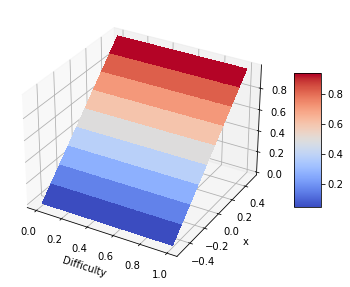

In [3]:
generator = Generator(embedding_size=1, hidden=[2, 2], activation=LeakyReLU())

difficulties = torch.linspace(0, 1, 10)
x = torch.linspace(0, 1, 10)
dataset = torch.cartesian_prod(difficulties, x)

with torch.no_grad():
    generated_states = generator(dataset)
    print(generated_states.reshape((10, 10)))

    # Generated states should repeat
    repeated_x = x.repeat(difficulties.shape[0])

    # ...and should be the same initially, as the input states
    # assert torch.all(generated_states == repeated_x.unsqueeze(-1))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
m_difficulties, m_x = np.meshgrid(remap(x), difficulties)
m_reshaped = generated_states.reshape((difficulties.shape[0], -1)).numpy()

surf = ax.plot_surface(m_x, m_difficulties, m_reshaped, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Difficulty")
ax.set_ylabel("x")
ax.set_zlabel("x")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

Good, now let's try training our generator

In [4]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

evaluator = MLP(1, 1, [2, 2], activation=LeakyReLU())

optim_generator = Adam(generator.parameters(), lr=0.001)
optim_evaluator = Adam(evaluator.parameters(), lr=0.001)

Preview of the embedding space and difficulties

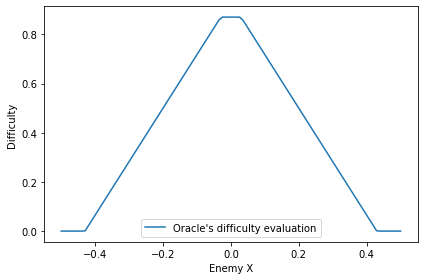

In [5]:
%matplotlib inline

enemy_x = np.linspace(enemy_x_min, enemy_x_max, 100)
evaluation = oracle(enemy_x)

axs = plt.subplot()

axs.plot(enemy_x, evaluation)
axs.set_xlabel("Enemy X")
axs.set_ylabel("Difficulty")
axs.legend(["Oracle's difficulty evaluation"])
plt.tight_layout()

plt.show()

We see that for the same difficulty, there exist several levels, that have the same difficulty.
However, with the way we've set up our generators, they can only output a single level for the given difficulty.

Now let's give the generator two inputs: the input difficulty $d_{in}$, as well the seed $\epsilon$

    Let's try with the simultaneous learning first

In [6]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
generator = Generator(embedding_size=1, hidden=[8, 8], activation=LeakyReLU())
optim_generator = Adam(generator.parameters(), lr=0.001, weight_decay=0.0001)

num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(0, 1, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)

iteration = 0
loss_evaluator = float("inf")


def iterate(verbose=False):
    global dataset, iteration
    indices = torch.randperm(dataset.shape[0])[:15]
    inputs = dataset[indices]

    states = generator(inputs)
    d_out = oracle(remap(states))

    d_in = inputs[:, :1]
    _seeds = inputs[:, 1:]

    seeds_difference = torch.norm(_seeds.unsqueeze(0) - _seeds.unsqueeze(1), dim=-1)
    states_difference = torch.norm(states.unsqueeze(0) - states.unsqueeze(1), dim=-1)

    difference = (seeds_difference * states_difference).mean() / 2

    loss_generator = F.l1_loss(d_in, d_out)
    loss = loss_generator - 0.15 * difference

    # Update the generator
    optim_generator.zero_grad()
    loss.backward()
    optim_generator.step()

    iteration += 1

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"(G) {loss_generator.item():.5f} "
              f"(diff) {difference.item():.5f}")

        print("Parameters:")
        for p in generator.parameters():
            print(p.data)

        difficulties = torch.linspace(0, 1, 10)
        seeds = torch.linspace(0, 1, 10)
        dataset = torch.cartesian_prod(difficulties, seeds)

        generated_states = generator(dataset).detach()

        d_out = oracle(remap(generated_states))

        collected = torch.hstack((dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(seeds.shape[0]):
            selected = collected[i::difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            # print(selected)
            # print()
            ax.plot(remap(xs), ds)

        ax.plot(remap(seeds), oracle(remap(seeds)))

        ax.legend([*[f"Seed {seed}" for seed in seeds], "Actual"])
        plt.tight_layout()

        plt.show()


iterate()

It.: 4061, (G) 0.00108 (diff) 0.02512
Parameters:
tensor([[ 0.1268,  0.4318],
        [ 0.2196, -0.1437],
        [ 0.2090, -0.1331],
        [ 0.0930,  0.3444],
        [ 0.0444,  0.4475],
        [-0.1039, -0.1582],
        [ 0.0526,  0.4748],
        [ 0.2943, -0.1949]])
tensor([ 0.1475,  0.1436,  0.1329,  0.1399,  0.1260, -0.1864,  0.1139,  0.1948])
tensor([[-0.0036,  0.3961,  0.3634,  0.0080, -0.0655, -0.0586, -0.0755,  0.4212],
        [-0.0072,  0.2297,  0.2267,  0.0218, -0.0355, -0.0400, -0.0467,  0.2276],
        [ 0.3253, -0.3295, -0.2206,  0.2588,  0.3556, -0.1563,  0.3714, -0.4778],
        [-0.0040,  0.2670,  0.2453,  0.0289, -0.0531, -0.0605, -0.0659,  0.3142],
        [-0.0081,  0.4319,  0.3236, -0.0420, -0.0605, -0.0472, -0.0602,  0.4512],
        [ 0.3133, -0.3198, -0.2132,  0.2645,  0.3554, -0.1534,  0.3947, -0.4929],
        [ 0.3159, -0.3339, -0.2303,  0.2653,  0.3833, -0.1517,  0.3679, -0.4980],
        [-0.0042,  0.2715,  0.2528,  0.0256, -0.0463, -0.0570, -0.0584

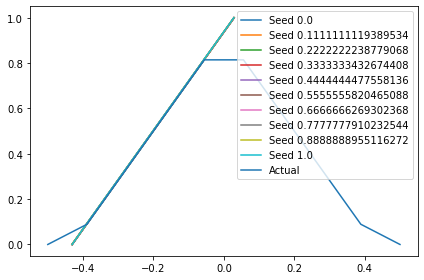

In [11]:
%matplotlib inline
try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

In [7]:
import matplotlib
% pylab
import matplotlib.pyplot as plt

set_matplotlib_colors(matplotlib)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

m_difficulties, m_x = np.meshgrid(x, difficulties)
m_reshaped = generated_states.reshape((difficulties.shape[0], -1)).numpy()

print(m_reshaped)

surf = ax.plot_surface(m_x, m_difficulties, m_reshaped, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Difficulty")
ax.set_ylabel("x")
ax.set_zlabel("x")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

UsageError: Line magic function `%` not found.


In [ ]:
% matplotlib inline
# %pylab
fig, axs = plt.subplots()

for i in range(15):
    selected = generated_states[i * 10:(i + 1) * 10].flatten()
    print(difficulties)
    print(oracle(selected))
    print(F.mse_loss(difficulties, oracle(selected)))
    print()
    axs.plot(selected, difficulties)

axs.legend([f"seed = {x1}" for x1 in x])
plt.tight_layout()
plt.show()